# <center> Freature Extraction using Spherical Clustering and Bag of Words </center>

In [1]:
import os
import numpy as np
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
from scipy.stats import multivariate_normal 

## Plotting the Train Images

(183, 275, 3)


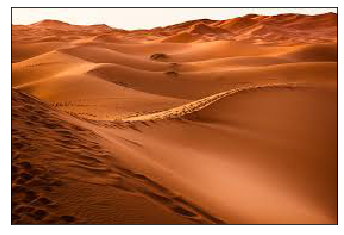

(275, 183, 3)


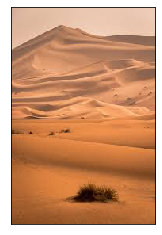

(194, 259, 3)


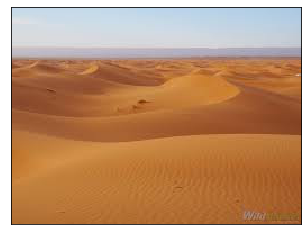

(143, 353, 3)


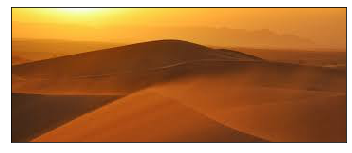

(225, 225, 3)


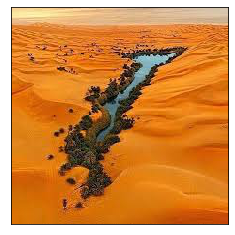

(173, 291, 3)


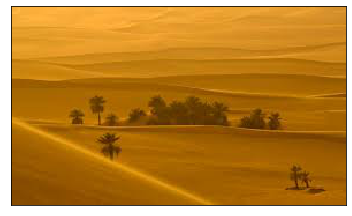

(194, 259, 3)


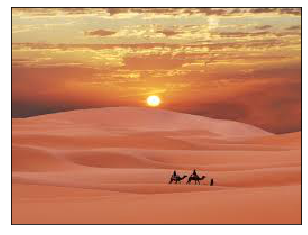

(184, 275, 3)


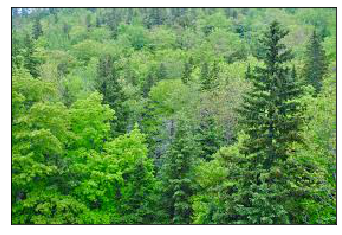

(168, 300, 3)


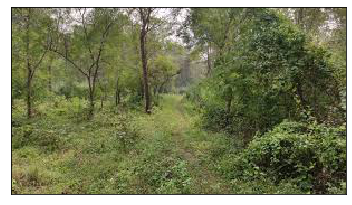

(177, 284, 3)


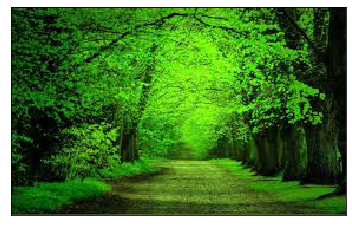

(182, 277, 3)


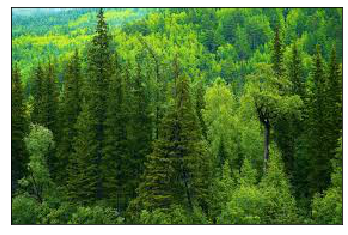

(174, 290, 3)


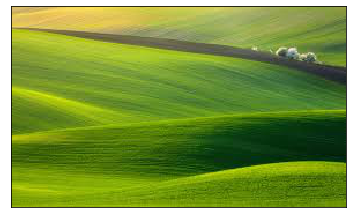

(212, 238, 3)


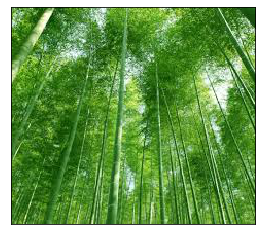

(168, 300, 3)


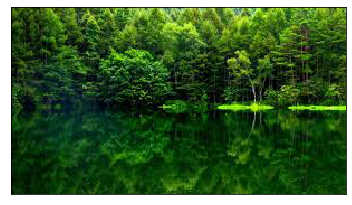

(183, 275, 3)


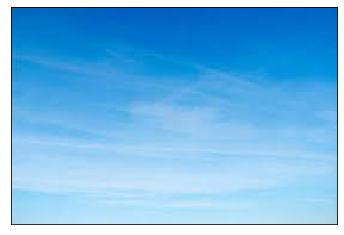

(183, 276, 3)


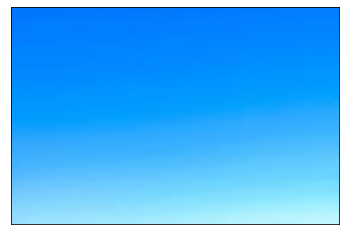

(183, 275, 3)


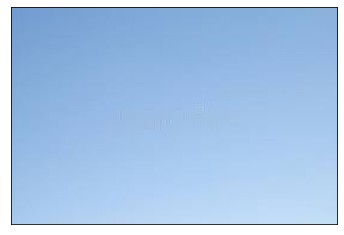

(183, 275, 3)


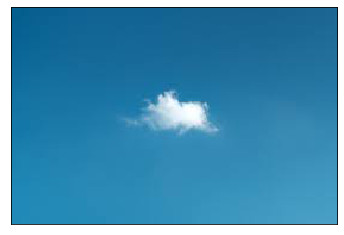

(180, 280, 3)


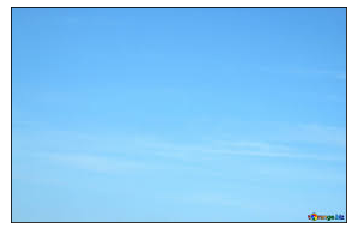

(194, 259, 3)


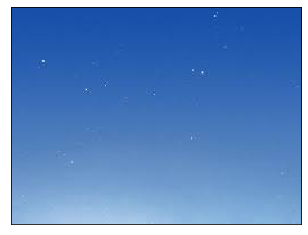

(179, 281, 3)


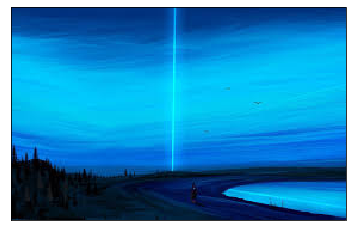

In [2]:
root = os.getcwd()
train_folder = os.path.join(root,"Train_images")
train_files = os.listdir(train_folder)
for i in range(len(train_files)):
    if train_files[i][-4:]==".jpg":
        file = os.path.join(train_folder,train_files[i])
        image_array = mpimg.imread(file)
        print(image_array.shape)
        plt.imshow(image_array)
        plt.xticks([]),plt.yticks([])
        plt.show()

In [3]:
## Bag of Words for the images patches
data_arr = []
for i in range(len(train_files)):
    if train_files[i][-4:]==".jpg":
        file = os.path.join(train_folder,train_files[i])
        image_array = mpimg.imread(file)
        image_patches = extract_patches_2d(image_array, (7, 7), max_patches = 100)
        for j in range(len(image_patches)):
            patch_vec = np.ravel(image_patches[j])
            data_arr.append(patch_vec)
data_arr = np.matrix(data_arr)
print(data_arr)
print(data_arr.shape)

[[194 101  58 ... 126  43   0]
 [162  78  32 ... 164  76  28]
 [125  66  34 ... 114  44   8]
 ...
 [  0 125 206 ...   0 189 235]
 [  3  12  19 ...  13  20  28]
 [ 12  19  27 ...  24  25  27]]
(2100, 147)


### Initialisation:

In [4]:
K = 3 ## K is the number of clusters that we want to create 
label_arr = np.zeros(data_arr.shape[0])
for i in range(len(label_arr)):                       
    label_arr[i] = np.random.choice(K)
print(label_arr)
print(np.unique(label_arr,return_counts=True))

[1. 1. 0. ... 0. 1. 1.]
(array([0., 1., 2.]), array([695, 728, 677], dtype=int64))


In [5]:
def similarity(vec1,vec2):
    
    vec1 = np.ravel(vec1)
    vec1 = vec1/np.linalg.norm(vec1)

    vec2 = np.ravel(vec2)
    vec2 = vec2/np.linalg.norm(vec2)
    
    sim = np.dot(vec1,vec2)
    
    return(sim)

In [6]:
def init_mean_cov(K,data_arr,label_arr):
    mean_ls = [] ## List containing mean values of the clusters
    cov_ls = []
    size_ls = []
    cluster_ls = [[] for k in range(K)] ## Create list of empty lists to store data belonging to a certain cluster
    
    for i in range(len(label_arr)):
        for k in range(K):
            if label_arr[i] == k:  ## if the label of the data at ith row is 'k'
                norm_data = np.ravel(data_arr[i,:])/np.linalg.norm(np.ravel(data_arr[i,:]))
                cluster_ls[k].append(norm_data) ## Fill the kth empty list with this data value                
    
    for k in range(K): 
        cluster_mat = np.matrix(cluster_ls[k])
        pointNum = cluster_mat.shape[0]
        cov_k = np.cov(cluster_mat.T)
        mean_k = np.mean(cluster_mat,axis=0)
        mean_k = np.ravel(mean_k)/np.linalg.norm(np.ravel(mean_k))
        mean_ls.append(mean_k)
        cov_ls.append(cov_k)
        size_ls.append(pointNum)
    return(mean_ls,cov_ls,size_ls)    

In [7]:
def label_update(prev_mean,data_arr,label_arr):
    for i in range(data_arr.shape[0]):
        dist_ls = [] 
        for k in range(len(prev_mean)):
            dist = similarity(data_arr[i,:],prev_mean[k]) ## Calculate the similarity of the ith datapoint with the kth mean
            dist_ls.append(dist) ## Put the distance values in a list
        dist_arr = np.array(dist_ls) ## Convert it to a NumPy array
        new_label = np.argmax(dist_arr) ##The new_label of the point is the one which is closest to the ith datapoint,i.e., it has maximum similarity
        label_arr[i] = new_label ## Set the new label
    return(label_arr)

In [8]:
def mean_from_label(K,prev_mean,prev_cov,prev_size,data_arr,label_arr):
    cluster_ls = [[] for k in range(K)]  ## Create list of empty lists to store data belonging to a certain cluster
    
    for i in range(data_arr.shape[0]):
        for k in range(K):
            if label_arr[i] == k: ## if the label of the pixel at location [i,j] is 'k'
                norm_data = np.ravel(data_arr[i,:])/np.linalg.norm(np.ravel(data_arr[i,:]))
                cluster_ls[k].append(norm_data) ## Fill the kth empty list with this pixel value
                    
    for k in range(K):
        if len(cluster_ls[k]) !=0:  ## Only update the means of those clusters which has received at least one new point, else retain the old mean value
            cluster_mat = np.matrix(cluster_ls[k])
            pointNum = cluster_mat.shape[0]
            mean_k = np.mean(cluster_mat,axis=0)
            cov_k = np.cov(cluster_mat.T)
            mean_k = np.ravel(mean_k)/np.linalg.norm(np.ravel(mean_k))
            prev_mean[k] = mean_k
            prev_cov[k] = cov_k
            prev_size[k] = pointNum
    new_mean = prev_mean
    new_cov = prev_cov
    new_size = prev_size
    return(new_mean,new_cov,new_size)    

In [9]:
def SphericalKMeans(data_arr,label_arr,K,maxIter):
    mean_old,cov_old,size_old = init_mean_cov(K,data_arr,label_arr)
    for t in range(maxIter):
        new_label_arr = label_update(mean_old,data_arr,label_arr)
        mean_new,cov_new,size_new = mean_from_label(K,mean_old,cov_old,size_old,data_arr,new_label_arr)
        label_arr = new_label_arr ## Update the label array
        mean_old = mean_new ## Update the mean values
        cov_old = cov_new
        size_old = size_new
        print("Iteration {} is complete during training!!".format(t+1))
    return(mean_new,cov_new,size_new)

In [10]:
mean_new,cov_new,size_new = SphericalKMeans(data_arr,label_arr,K,30)

Iteration 1 is complete during training!!
Iteration 2 is complete during training!!
Iteration 3 is complete during training!!
Iteration 4 is complete during training!!
Iteration 5 is complete during training!!
Iteration 6 is complete during training!!
Iteration 7 is complete during training!!
Iteration 8 is complete during training!!
Iteration 9 is complete during training!!
Iteration 10 is complete during training!!
Iteration 11 is complete during training!!
Iteration 12 is complete during training!!
Iteration 13 is complete during training!!
Iteration 14 is complete during training!!
Iteration 15 is complete during training!!
Iteration 16 is complete during training!!
Iteration 17 is complete during training!!
Iteration 18 is complete during training!!
Iteration 19 is complete during training!!
Iteration 20 is complete during training!!
Iteration 21 is complete during training!!
Iteration 22 is complete during training!!
Iteration 23 is complete during training!!
Iteration 24 is comp

In [11]:
prior_ls = size_new/np.sum(size_new)
print(prior_ls)

[0.34761905 0.32333333 0.32904762]


In [12]:
def testImage(img_file,mean_new,cov_new,prior_ls):
    img_arr = mpimg.imread(img_file)
    img_patches = extract_patches_2d(img_arr, (7, 7), max_patches = 100)
    test_arr = []
    for i in range(len(img_patches)):
        patch_vec = np.ravel(img_patches[i])
        test_arr.append(patch_vec)
    test_arr = np.matrix(test_arr)
    print(test_arr.shape)
    for j in range(test_arr.shape[0]):
        feat_vec = []
        for k in range(len(size_new)):
#             var = multivariate_normal(mean = mean_new[k],cov = cov_new[k])
            test1 = np.ravel(test_arr[j,:])
            test_sample = test1/np.linalg.norm(test1)
            post = np.dot(test_sample,mean_new[k])
#             lkl = var.pdf(test_sample)
#             post = lkl*prior_ls[k]
            feat_vec.append(post)
        print(feat_vec/sum(feat_vec))

In [13]:
test_folder = os.path.join(root,"Test_Images")
img_files = os.listdir(test_folder)
fileName = np.random.choice(img_files)
print(fileName)
filePath = os.path.join(test_folder,fileName)
testImage(filePath,mean_new,cov_new,prior_ls)

test_img4.jpg
(100, 147)
[0.37734842 0.26783551 0.35481607]
[0.36528917 0.26761458 0.36709624]
[0.35171919 0.28723891 0.3610419 ]
[0.34664412 0.28961271 0.36374317]
[0.3235243  0.31395409 0.36252161]
[0.34589462 0.28212256 0.37198282]
[0.34203925 0.2940834  0.36387735]
[0.33441038 0.29845987 0.36712975]
[0.34440483 0.28792728 0.3676679 ]
[0.3492035  0.28975651 0.36103998]
[0.364168   0.27855312 0.35727889]
[0.34323882 0.28985517 0.36690601]
[0.35077561 0.28529014 0.36393425]
[0.33552089 0.29367449 0.37080462]
[0.35077392 0.29105445 0.35817163]
[0.34770336 0.28609853 0.3661981 ]
[0.39412878 0.25141025 0.35446097]
[0.34000648 0.28406926 0.37592426]
[0.35499833 0.28153601 0.36346566]
[0.36354655 0.26356006 0.3728934 ]
[0.34804291 0.2836038  0.3683533 ]
[0.33880977 0.29183846 0.36935177]
[0.31740357 0.30934599 0.37325044]
[0.34554021 0.28397842 0.37048137]
[0.3477302  0.28089043 0.37137937]
[0.36303987 0.26192468 0.37503545]
[0.34125488 0.29952719 0.35921793]
[0.37383612 0.26888508 0.35727